In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

pd.set_option("mode.chained_assignment", None)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")

# Uciml repo
from ucimlrepo import fetch_ucirepo

# Pytorch device specific configuration
# Pytorch Gpu Configuration for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for dml devices
# import torch_directml

# device = torch_directml.device()

# Set default devices
torch.set_default_device(device)

In [3]:
# import the data
# Import heart desease data
heart_disease = pd.read_csv("../Datasets/heart-disease-dataset.csv", sep=",")

labels = heart_disease["target"]
data = heart_disease.drop(columns=["target"])
print(data.keys(), labels.keys())
# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(["sex", "fasting_blood_sugar", "exercise_angina"])
cols2zscore

for c in cols2zscore:
    d = pd.to_numeric(data[c])  # force to numeric (addresses some data-format issues)
    data[c] = (d - d.mean()) / d.std(ddof=1)

#### Data pre-processing ####
# Filling nan values with it's mean
keys = data.keys()
for key in keys:
    # print(f"{key} before filling na count: {data[key].isna().sum()}")
    data[key] = data[key].fillna(data[key].mean())
    # print(f"{key} after filling na count: {data[key].isna().sum()}")

# Binarized labels
labels = labels.values > 0
data = data.values
labels = labels.reshape(labels.shape[0], 1)
print(data.shape, labels.shape)

Index(['age', 'sex', 'chest_pain_type', 'resting_bp_s', 'cholesterol',
       'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate',
       'exercise_angina', 'oldpeak', 'st_slope'],
      dtype='object') RangeIndex(start=0, stop=1190, step=1)
(1190, 11) (1190, 1)


In [4]:
# convert data into tensors
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).float()

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, train_size=0.8
)
# Data over sampling
train_data = torch.concat((train_data, train_data))
train_labels = torch.concat((train_labels, train_labels))
# Pytorch datasets
train_dataT = TensorDataset(train_data, train_labels)
test_dataT = TensorDataset(test_data, test_labels)

# Lead data into data loaders
batchSize = 8
train_loader = DataLoader(
    train_dataT,
    batch_size=batchSize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [5]:
def createTheModel():
    class PredictHeartDisease(nn.Module):
        def __init__(self):
            super().__init__()

            self.dr = 0.5
            # Input Layer
            self.input = nn.Linear(11, 64)
            # Hidden Layers
            self.hidden1 = nn.Linear(64, 256)
            self.hidden2 = nn.Linear(256, 512)
            self.hidden3 = nn.Linear(512, 256)
            self.hidden4 = nn.Linear(256, 128)
            self.hidden5 = nn.Linear(128, 16)
            # Output Layers
            self.output = nn.Linear(16, 1)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden1(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden2(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden3(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden4(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            x = F.relu(self.hidden5(x))
            x = F.dropout(x, p=self.dr, training=self.training)
            return self.output(x)

    net = PredictHeartDisease()

    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [6]:
# Test the model for errors
net, lossFun, optimizer = createTheModel()
tempData = torch.randint(low=-1, high=2, size=(100, 11)).float()
net(tempData)

tensor([[-0.0220],
        [-0.0475],
        [-0.0343],
        [-0.0276],
        [-0.0156],
        [-0.0240],
        [-0.0270],
        [-0.0477],
        [-0.0480],
        [-0.0867],
        [-0.0334],
        [-0.0927],
        [-0.0308],
        [-0.0492],
        [-0.0587],
        [-0.0265],
        [-0.0175],
        [-0.0287],
        [-0.0528],
        [-0.0228],
        [-0.0194],
        [-0.0319],
        [-0.0339],
        [-0.0382],
        [-0.0044],
        [-0.0924],
        [ 0.0048],
        [-0.0497],
        [-0.0284],
        [-0.0006],
        [-0.0508],
        [-0.0564],
        [-0.0674],
        [-0.0755],
        [-0.0017],
        [ 0.0258],
        [-0.0323],
        [-0.0453],
        [-0.0005],
        [-0.0478],
        [ 0.0060],
        [-0.0970],
        [-0.1232],
        [-0.0094],
        [-0.0830],
        [-0.0821],
        [-0.0446],
        [-0.0330],
        [-0.1082],
        [-0.0411],
        [-0.0372],
        [-0.0115],
        [-0.

In [7]:
# Train the model function
def trainTheModel(nEpochs):

    # Loss and accuracy initialization
    trainAcc = []
    testAcc = []
    losses = np.zeros(nEpochs)

    # The Loop
    for epoch in range(nEpochs):
        # Model in training model
        net.train()

        # Batch accuracy and loss
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accuracies
            batchAcc.append(
                100
                * torch.mean((((torch.sigmoid(yHat) > 0.5).float()) == y).float()).cpu()
            )
            batchLoss.append(loss.cpu().item())

        # Batch Loop finished
        # Training loss and accuracy
        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        # Evaluate the model performance
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(
            100 * torch.mean((((torch.sigmoid(yHat) > 0.5).float()) == y).float()).cpu()
        )

    return trainAcc, testAcc, losses

In [8]:
net, lossFun, optimizer = createTheModel()
nEpochs = 500
trainAcc, testAcc, losses = trainTheModel(nEpochs=nEpochs)

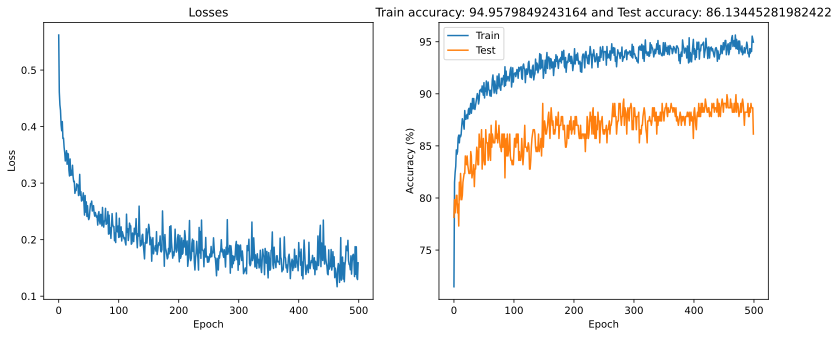

In [9]:
# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(losses)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title(f"Train accuracy: {trainAcc[-1]} and Test accuracy: {testAcc[-1]}")
ax[1].legend()
plt.show()

plt.show()